In [21]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats

# Context And Hypothesis

Currently, the strategy is defined as follows:

For each pair of the stocks, we calculate the past 20 trading days absolute differences' average (M) and standard deviation (std). Then we execute pair strategy when the observed spread is above 1.5 std away from M in the next 20 day window. 

Today, our model predicts whether the entry signal appears within 1-3 days in the future. Hence we would like to understand the following:

1. In general, with the strategy as defined, what is the win-rate of PNL after entry? How are the two variables correlated?
2. Is the relationship of PNL and predicted entry signal probability linear? Are we expecting higher PNL with higher predicted probability of entry signals? 

# Load data and model

In [41]:
data = pd.read_csv('Data/transformed_data.csv')

with open('Outputs/xgb_st_entry.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

## Relationship Between Entry and PNL

In [20]:
sub_tb = data[['direction_longterm_entry_0.5',
       'direction_shortterm_entry_0.5', 'direction_longterm_entry_1',
       'direction_shortterm_entry_1', 'direction_longterm_entry_1.5',
       'direction_shortterm_entry_1.5', 'direction_longterm_entry_2',
       'direction_shortterm_entry_2', 'direction_longterm_exit',
       'direction_shortterm_exit','num_entries','pnls','both_legs_profited']]

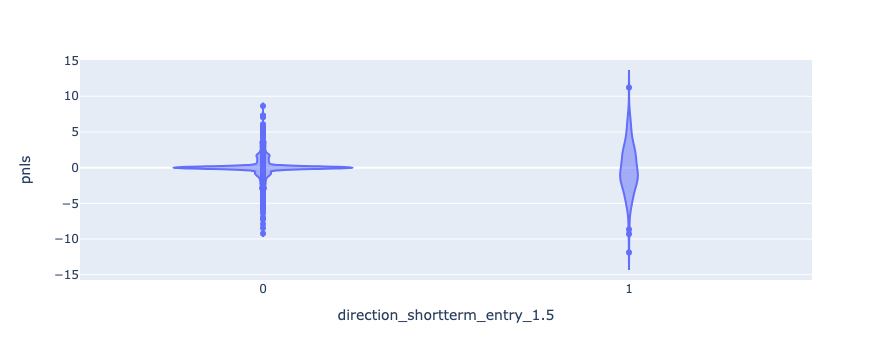

In [28]:
fig = px.violin(sub_tb.sample(1000), y="pnls", x="direction_shortterm_entry_1.5")
fig.show()

In [39]:
col_of_interest = 'direction_shortterm_entry_2'
sub_tb[[col_of_interest,'pnls']].groupby(col_of_interest).describe()

pnls                                 \
                                count      mean       std        min   
direction_shortterm_entry_2                                            
0                            670218.0  0.056927  2.181003 -21.332920   
1                             79974.0  0.128402  3.554710 -18.668578   

                                                                      
                                  25%       50%       75%        max  
direction_shortterm_entry_2                                           
0                           -0.050534  0.000000  0.338847  21.134249  
1                           -2.182366  0.103413  2.460756  18.869380

In [40]:
sub_tb[[col_of_interest,'both_legs_profited']].groupby(col_of_interest).agg(['mean','size'])

both_legs_profited        
                                          mean    size
direction_shortterm_entry_2                           
0                                     0.122406  670218
1                                     0.225511   79974

In [31]:
sample1 = sub_tb[sub_tb['direction_shortterm_entry_2']==1]['pnls'].values

t_stat, p_value = stats.ttest_1samp(sample1, 0)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 10.215069304095767
P-value: 1.7574428403368533e-24


## Relationship between predicted probability and pnls

In [44]:
input_data = data[xgb_model.features_names]
input_data_scaled = xgb_model.feature_scaler.transform(input_data)

In [46]:
pred_proba = [x[1] for x in xgb_model.predict_proba(input_data_scaled)]

In [48]:
sub_tb['predicted_prob_st_entry_1.5'] = pred_proba

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_60186/2401864217.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:

# Define the bins for the categories
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Define the labels for the categories
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']


In [52]:
sub_tb['pred_proba_cate'] = pd.cut(sub_tb['predicted_prob_st_entry_1.5'], bins=bins, labels=labels, right=False)

In [63]:
sub_tb[['pred_proba_cate','pnls']].groupby('pred_proba_cate').describe()

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_60186/1180258647.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



pnls                                                \
                    count      mean       std        min       25%  50%   
pred_proba_cate                                                           
0-0.1            360617.0  0.071306  2.193001 -20.584262  0.000000  0.0   
0.1-0.2            9415.0  0.056319  2.391770 -15.586069 -0.180508  0.0   
0.2-0.3            6552.0  0.032699  2.249408 -16.140584 -0.094248  0.0   
0.3-0.4            5376.0  0.014574  2.350139 -14.620887 -0.221691  0.0   
0.4-0.5            5253.0  0.027860  2.311993 -13.952149 -0.187445  0.0   
0.5-0.6            5358.0  0.009177  2.244103 -14.999369 -0.199865  0.0   
0.6-0.7            5872.0  0.036759  2.292316 -15.163379 -0.233599  0.0   
0.7-0.8            7346.0  0.043422  2.378808 -15.776278 -0.156476  0.0   
0.8-0.9           11168.0  0.042139  2.312881 -15.471312 -0.181949  0.0   
0.9-1.0          310566.0  0.061740  2.520606 -21.332920 -0.734827  0.0   

                                      
                      75%        max  
pred_proba_cate                       
0-0.1            0.221751  21.134249  
0.1-0.2          0.398004  13.769554  
0.2-0.3          0.274131  15.030742  
0.3-0.4          0.309307  15.742306  
0.4-0.5          0.426669  15.386980  
0.5-0.6          0.356013  15.224060  
0.6-0.7          0.350136  15.852379  
0.7-0.8          0.467697  15.004415  
0.8-0.9          0.418747  18.656792  
0.9-1.0          0.941221  18.846802

In [65]:
agg_prob_pnlsmean = sub_tb[['pred_proba_cate','pnls']].groupby('pred_proba_cate').mean().reset_index(drop=False)
agg_prob_bothlegprof = sub_tb[['pred_proba_cate','both_legs_profited']].groupby('pred_proba_cate').mean().reset_index(drop=False)

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_60186/2859262244.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_60186/2859262244.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



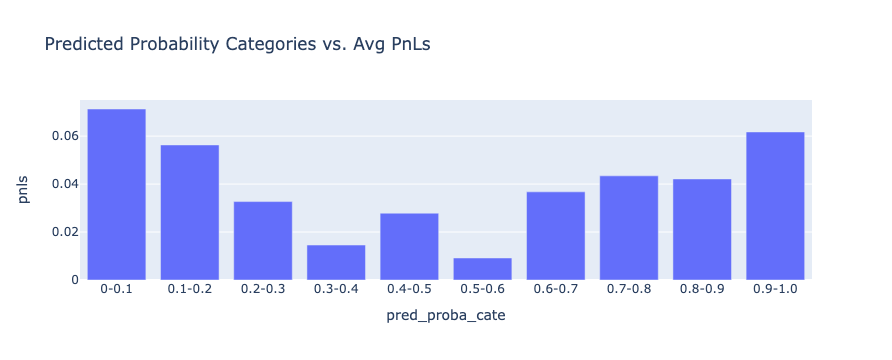

In [62]:
fig = px.bar(agg_prob_pnlsmean, x='pred_proba_cate', y='pnls', title='Predicted Probability Categories vs. Avg PnLs')
fig.show()

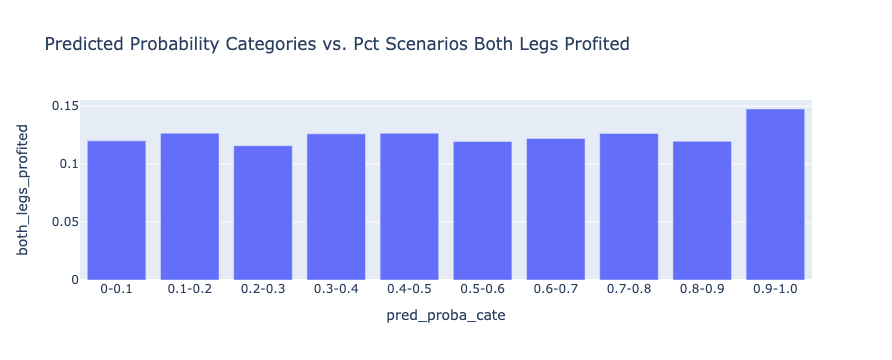

In [68]:
fig = px.bar(agg_prob_bothlegprof, x='pred_proba_cate', y='both_legs_profited', title='Predicted Probability Categories vs. Pct Scenarios Both Legs Profited')
fig.show()